# 🦒 Fine-tuning Cellpose with BioEngine ⚙️☁️

## Installation and module imports

In [1]:
try:
    # For pyodide in the browser
    import micropip

    await micropip.install(["pyodide-http", "hypha-rpc", "httpx"])

    # 2. Patch requests
    import pyodide_http

    pyodide_http.patch_all()  # Patch all libraries
except ImportError:
    # For native python with pip
    import subprocess

    subprocess.call(["pip", "install", "hypha-rpc", "kaibu-utils", "matplotlib"])

from pathlib import Path

import httpx
from hypha_rpc import connect_to_server, login

In [2]:
# Server URL: For this demo we will use the hypha.aicell.io server
SERVER_URL = "https://hypha.aicell.io"

### Connect to the server

In [3]:
token = await login({"server_url": SERVER_URL})

server = await connect_to_server(
    {"server_url": SERVER_URL, "token": token}
)
workspace = server.config.workspace

print(f"Connected to workspace: {workspace}")

artifact_manager = await server.get_service("public/artifact-manager")

Please open your browser and login at https://hypha.aicell.io/public/apps/hypha-login/?key=iRhoz7q9AMx9hhcpqjjkVM
Connected to workspace: ws-user-github|49943582


### Access the BioEngine deployments

A public BioEngine instance is available with the service ID `bioimage-io/bioengine-apps`

In [4]:
PUBLIC_BIOENGINE = "bioimage-io/bioengine-apps"

bioengine = await server.get_service(PUBLIC_BIOENGINE)

### Visualize some collected data

In [ ]:
from pathlib import Path

image_dir = Path(data_dir) / "hpa_demo"
annotations_dir = image_dir / "annotations"

# List to hold pairs of image and corresponding annotation masks
image_annotation_pairs = []

# Get list of all images and annotations
annotation_files = list(annotations_dir.glob("*.tif"))

# Iterate through each annotation file
for annotation_file in annotation_files:
    annotation_name = annotation_file.name
    image_name = annotation_name.split("_mask_")[0]
    image_file = image_dir / f"{image_name}.tif"

    image_annotation_pairs.append((image_file, annotation_file))


# Print the number of annotations
print(f"Number of annotations: {len(image_annotation_pairs)}")

In [ ]:
# import matplotlib.pyplot as plt
# from tifffile import imread

# assert len(image_annotation_pairs) >= 5


# # Plot several random annotations
# choices = np.random.choice(len(image_annotation_pairs), 5, replace=False)
# plt.figure(figsize=(15, 6))

# for i in range(5):
#     plt.subplot(2, 5, i + 1)
#     img = imread(image_annotation_pairs[choices[i]][0])
#     plt.imshow(img.transpose(1, 2, 0))
#     plt.title(f"{image_annotation_pairs[choices[i]][0].stem}")
#     plt.axis("off")

#     plt.subplot(2, 5, i + 6)
#     mask = imread(image_annotation_pairs[choices[i]][1])
#     plt.imshow(mask)
#     plt.axis("off")

# plt.tight_layout()
# plt.show()

### Create the dataset collection (if not already created)

In [ ]:
# Check if the data collection exists
collection_id = f"{workspace}/bioimageio-colab"

try:
    await artifact_manager.read(collection_id)
except Exception as e:
    expected_error = f'KeyError: "Artifact with ID \'{collection_id}\' does not exist."'
    if str(e).strip().endswith(expected_error):
        print(f"Collection '{collection_id}' does not exist. Creating it.")

    collection_manifest = {
        "name": "BioImage.IO Colab",
        "description": "A collection of annotated images from BioImage.IO Colab.",
    }
    collection = await artifact_manager.create(
        alias=collection_id,
        type="collection",
        manifest=collection_manifest,
        config={"permissions": {"*": "r", "@": "r+"}}
    )
    print(f"BioImage.IO Colab data collection created with ID: {collection.id}")

### Upload the annotated dataset to the collection

In [6]:
# Load the dataset content
data_path = Path.cwd().parent / "data" / "hpa_demo" / "data.zip"
dataset_content = data_path.read_bytes()

# Create or update the dataset artifact
dataset_manifest = {
    "name": "HPA Demo",
    "description": "An annotated dataset for Cellpose finetuning",
    "type": "data",
}
data_artifact_alias = "hpa-demo"

try:
    # Edit the existing deployment and stage it for review
    artifact = await artifact_manager.edit(
        artifact_id=f"{workspace}/{data_artifact_alias}",
        manifest=dataset_manifest,
        type=dataset_manifest["type"],
        version="stage",
    )
except:
    # If the artifact does not exist, create it
    artifact = await artifact_manager.create(
        alias=data_artifact_alias,
        parent_id=collection_id,
        manifest=dataset_manifest,
        type=dataset_manifest["type"],
        version="stage",
    )
    print(f"Artifact created with ID: {artifact.id}")

# Upload manifest.yaml
manifest_url = await artifact_manager.put_file(artifact.id, file_path="manifest.yaml")
async with httpx.AsyncClient(timeout=30) as client:
    response = await client.put(manifest_url, data=dataset_manifest)
    response.raise_for_status()
    print(f"Uploaded manifest.yaml to artifact")

# Upload the dataset content as a zip file
data_url = await artifact_manager.put_file(artifact.id, file_path="data.zip")
async with httpx.AsyncClient(timeout=30) as client:
    response = await client.put(data_url, data=dataset_content)
    response.raise_for_status()
    print(f"Uploaded data.zip to artifact")

# Commit the artifact
await artifact_manager.commit(
    artifact_id=artifact.id,
    version="new",
)
print(f"Committed artifact with ID: {artifact.id}")

Uploaded manifest.yaml to artifact
Uploaded data.zip to artifact
Committed artifact with ID: ws-user-github|49943582/hpa-demo


### Prepare the data for training

Create an artifact for the fine-tuned Cellpose model

In [7]:
model_manifest = {
    "name": "Finetuned Cellpose model",
    "description": "Finetuned model for Cellpose cyto3",
    "type": "model",
}
model_artifact_alias = "cellpose-cyto3-hpa-finetuned"

try:
    model_artifact = await artifact_manager.create(
        alias=model_artifact_alias,
        parent_id=collection_id,
        manifest=model_manifest,
        type=model_manifest["type"],
        version="stage",
    )
except:
    model_artifact_id = f"{workspace}/{model_artifact_alias}"
    answer = input(
        f"Artifact {model_artifact_id} already exists. Do you want to overwrite it? (y/n): "
    )
    if answer.lower() != "y":
        raise RuntimeError(
            f"Artifact {model_artifact_id} already exists and will not be overwritten."
        )

    # Overwrite the existing artifact
    model_artifact = await artifact_manager.edit(
        artifact_id=f"{workspace}/{model_artifact_alias}",
        manifest=model_manifest,
        type=model_manifest["type"],
        version="stage",
    )

In [8]:
# Create presigned URLs for data download and model upload
data_download_url = await artifact_manager.get_file(
    artifact_id=f"{workspace}/{data_artifact_alias}", file_path="data.zip"
)

model_upload_url = await artifact_manager.put_file(
    model_artifact.id, file_path=model_artifact_alias.replace("-", "_")
)

data = {
    "data_download_url": data_download_url,
    "model_upload_url": model_upload_url,
    "initial_model": "cyto3",
}

### Run the Cellpose fine-tuning

In [9]:
result = await bioengine.bioimage_io_cellpose_finetuning.train(data=data)
await artifact_manager.commit(artifact_id=model_artifact.id)
print(f"Committed artifact with ID: {model_artifact.id}")

print(f"Average precision at iou threshold 0.5: {result['final_average_precision']['0.5']:.3f}")

Committed artifact with ID: ws-user-github|49943582/cellpose-cyto3-hpa-finetuned
Average precision at iou threshold 0.5: 0.521


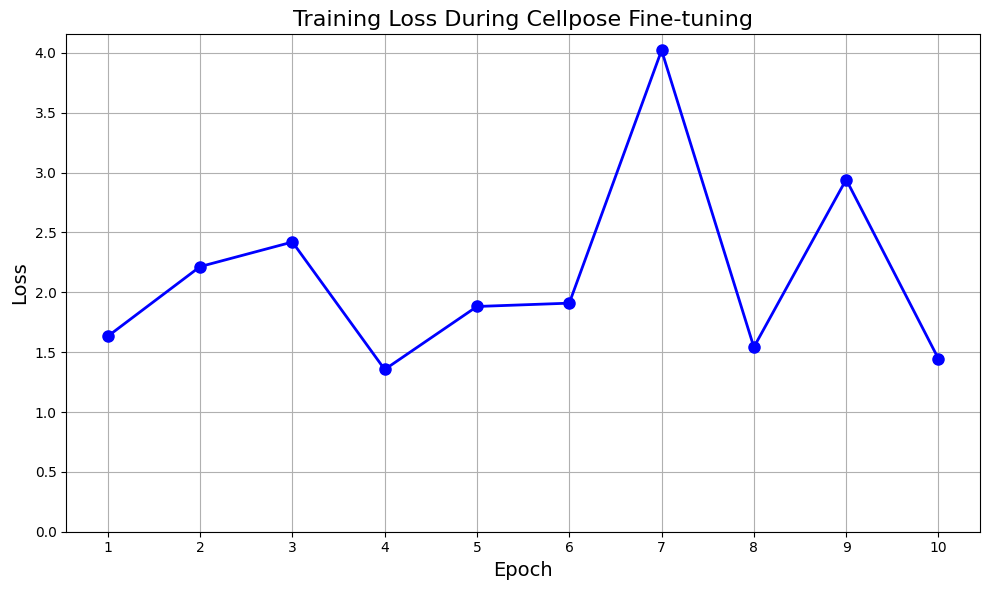

In [12]:
import matplotlib.pyplot as plt

# Extract training losses from the result
train_losses = result["train_losses"]
epochs = range(1, len(train_losses) + 1)

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, 'bo-', linewidth=2, markersize=8)
plt.title('Training Loss During Cellpose Fine-tuning', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.xticks(epochs)
plt.ylim(bottom=0)  # Start y-axis at 0

plt.tight_layout()
plt.show()

Number of test samples: 2
Image shape: (3, 512, 512)
Predicted mask shape: (512, 512)
True mask shape: (512, 512)


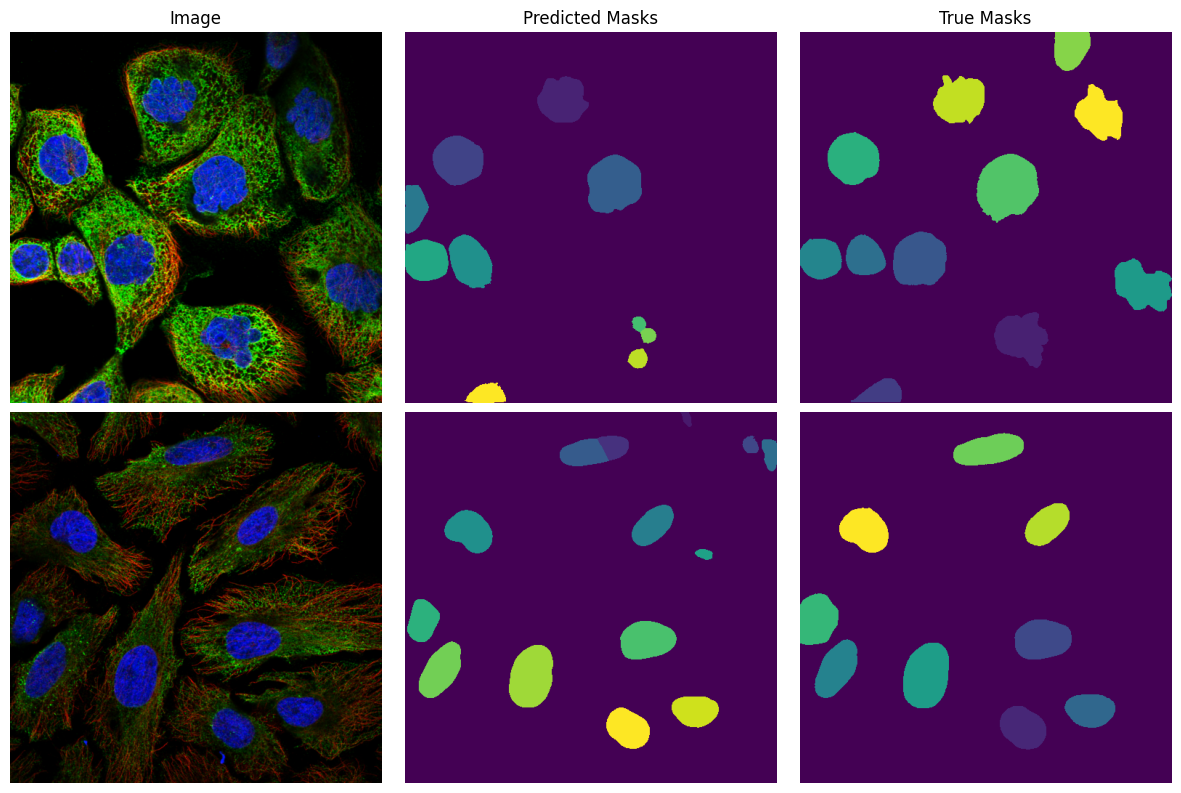

In [17]:
import numpy as np

import matplotlib.pyplot as plt

# Extract the prediction data from the result
predictions = result["predictions"]
n_samples = len(predictions)

# Print some information about the prediction results
print(f"Number of test samples: {n_samples}")
print(f"Image shape: {predictions[0][0].shape}")
print(f"Predicted mask shape: {predictions[0][2].shape}")
print(f"True mask shape: {predictions[0][1].shape}")

# Plot the images, predictions, and ground truth labels
plt.figure(figsize=(12, 4 * n_samples))

for i in range(n_samples):
    # Plot the image
    plt.subplot(n_samples, 3, i * 3 + 1)
    plt.imshow(predictions[i][0].transpose(1, 2, 0))
    plt.title("Image" if i == 0 else "")
    plt.axis("off")
    
    # Plot the predicted labels
    plt.subplot(n_samples, 3, i * 3 + 2)
    plt.imshow(predictions[i][2])
    plt.title("Predicted Masks" if i == 0 else "")
    plt.axis("off")
    
    # Plot the true labels
    plt.subplot(n_samples, 3, i * 3 + 3)
    plt.imshow(predictions[i][1])
    plt.title("True Masks" if i == 0 else "")
    plt.axis("off")

plt.tight_layout()
plt.show()

NameError: name 'test_data' is not defined

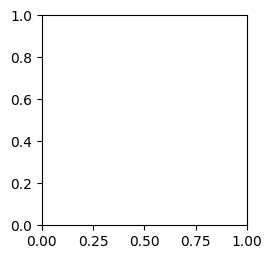

In [15]:
plt.figure(figsize=(9, 6))

for i in range(2):  # Two rows
    # Plot the image
    plt.subplot(2, 3, i * 3 + 1)
    plt.imshow(test_data[i].transpose(1, 2, 0))
    plt.axis("off")
    if i == 0:
        plt.title("Image")

    # Plot the predicted labels
    plt.subplot(2, 3, i * 3 + 2)
    plt.imshow(masks[i])
    plt.axis("off")
    if i == 0:
        plt.title("Predicted Labels")

    # Plot the true labels
    plt.subplot(2, 3, i * 3 + 3)
    plt.imshow(test_labels[i])
    plt.axis("off")
    if i == 0:
        plt.title("True Labels")

plt.tight_layout()
plt.show()